Linear Approximator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from env import draw_card, step, enc_state, cards, get_lin_action
from matplotlib import cm
from tqdm import trange, tqdm
from datetime import datetime
import os

np.random.seed(1234567890)

In [2]:
os.chdir("/home/guest/Desktop/Om/Stuff/Reinforce/")
W = np.random.uniform(-1,1,(36,))
Q_star = np.load("MC_Results 2024-07-21 19:26:46.469298/Q_star_MC.npy")

def Lin_Approx(ep, lam):
    global W
    global Q_star
    
    for e in range(ep):
        disc = 1
        
        ET = np.zeros((36,))
        curr = (np.random.choice(cards), np.random.choice(cards))
        act = get_lin_action(curr, W)
        S = enc_state(curr, act)
        
        t = 0
        
        while t == 0:
            curr_n, rew, t = step(curr, act)
            act_n = get_lin_action(curr_n, W)
            S_n = enc_state(curr_n, act_n)
            
            ET = lam*disc*ET + S
            ET = np.minimum(ET, 1)                         # Replacing Trace
            a = 0.05
            err = rew + disc*np.einsum("i,i -> ", W, S_n) - np.einsum("i,i -> ", W, S)
            disc *= disc
            W = W + a*err*ET
            curr = curr_n
            act = act_n
            S = S_n
        
        sq_err = 0
        
        for j in range(21):
            for i in range(10):
                for a in range(2):
                    St = enc_state((j,i), a)
                    sq_err += (Q_star[j][i][a] - np.einsum("i,i -> ", W, St))**2
        
        return sq_err/(21*10*2)

In [3]:
os.chdir("/home/guest/Desktop/Om/Stuff/Reinforce/")
name = f"LinApprox {datetime.now()}"
os.mkdir(name)
os.chdir(name)

100%|███████████████████████████████████████████| 11/11 [00:04<00:00,  2.28it/s]


<IPython.core.display.Javascript object>


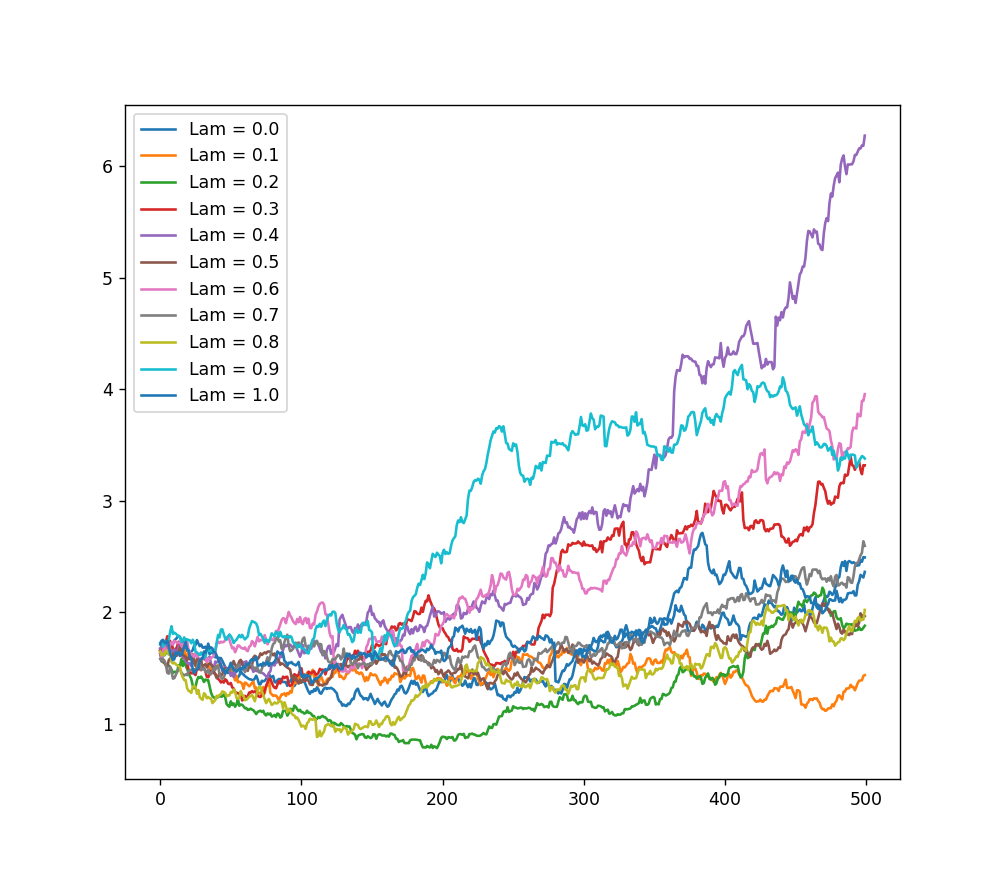

In [4]:
mseLin = []

W_init = np.random.normal(size=(36,))

for lam in tqdm(np.arange(0,1.1,0.1)):
    W = W_init.copy()
    run =[]
    for l in range(500):
        run.append(Lin_Approx(100, lam))
    mseLin.append(run)
    
%matplotlib notebook
plt.figure(figsize=(8,7))
for i,data in enumerate(mseLin):
    plt.plot(range(len(data)), data, label=f"Lam = {i/10}",)
    
plt.legend()
plt.savefig("Lam Sweep")
plt.show()

In [5]:
def benchmark():
    wins = 0
    
    for l in range(1000):
        curr = (np.random.choice(cards), np.random.choice(cards))
        act = get_lin_action(curr, W)
        S = enc_state(curr, act)
        
        t = 0

        while t == 0:
            curr_n, rew, t = step(curr, act)
            act_n = get_lin_action(curr_n, W)
            S_n = enc_state(curr_n, act_n)

            curr = curr_n
            act = act_n
            S = S_n

        if rew >= 0:
            wins+=1
        
    return wins

# Lam = 0

100%|███████████████████████████████████████| 2000/2000 [01:25<00:00, 23.48it/s]


<IPython.core.display.Javascript object>


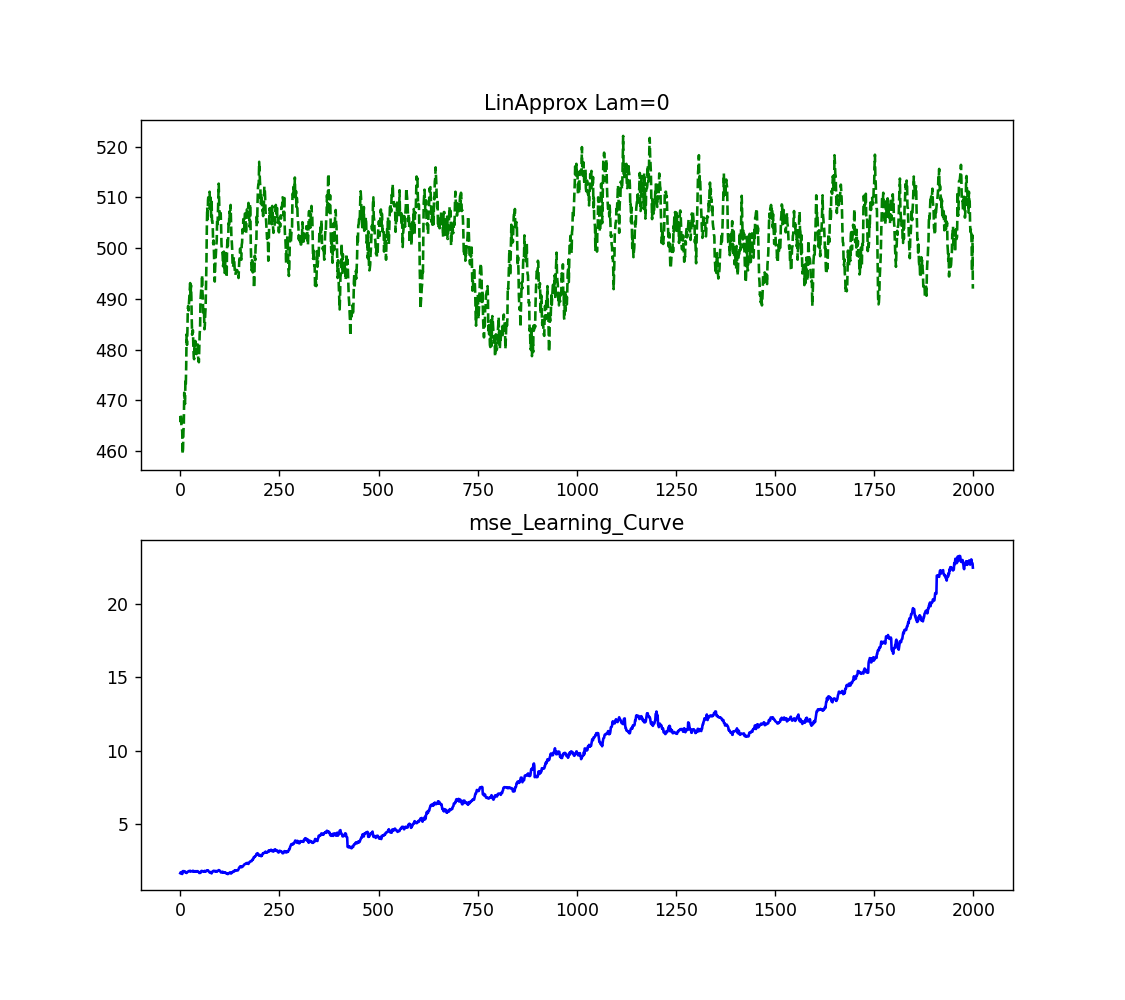

In [6]:
W = W_init.copy()
best = 0
win_history = []
mse_history = []

for i in trange(2000):
    mse_history.append(Lin_Approx(100, 0))
    win_history.append(benchmark())
    if np.average(win_history[-10:]) > best:
        np.save("Best_W_0.npy", W)
        best = np.average(win_history[-10:])
        best_i = i

rolling_wins =[]
roll = 10
i = 0

for i in range(len(win_history)):
    rolling_wins.append(np.average(win_history[i:i+roll]))

%matplotlib notebook
plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.plot(range(len(rolling_wins)), rolling_wins, 'g--')
plt.title("LinApprox Lam=0")
plt.subplot(2,1,2)
plt.plot(range(len(mse_history)), mse_history, 'b')
plt.title("mse_Learning_Curve")
plt.savefig("Lam=0")
plt.show()

# Trained Agent Performance

In [7]:
best_i

1126

In [8]:
W = np.load("Best_W_0.npy")

wins = 0

for l in trange(1_00_000):
    curr = (np.random.choice(cards), np.random.choice(cards))
    act = get_lin_action(curr, W)
    S = enc_state(curr, act)
    
    t = 0

    while t == 0:
        curr_n, rew, t = step(curr, act)
        act_n = get_lin_action(curr_n, W)
        S_n = enc_state(curr_n, act_n)

        curr = curr_n
        act = act_n
        S = S_n

    if rew >= 0:
        wins+=1

print(wins)

100%|████████████████████████████████| 100000/100000 [00:04<00:00, 22861.91it/s]

51287


# Random Agent Performance

In [9]:
wins = 0

for l in trange(1_00_000):
    curr = (np.random.choice(cards), np.random.choice(cards))
    act = np.random.randint(0,2)
    
    t = 0

    while t == 0:
        curr, rew, t = step(curr, act)
        act = np.random.randint(0,2)

    if rew >= 0:
        wins+=1

print(wins)

100%|████████████████████████████████| 100000/100000 [00:02<00:00, 40631.84it/s]

44939


In [10]:
Q = np.zeros((21, 10,2))

for j in range(21):
    for i in range(10):
        for a in range(2):
            St = enc_state((j,i), a)
            Q[j][i][a] = np.einsum("l,l -> ", W, enc_state((j,i),a))

<IPython.core.display.Javascript object>


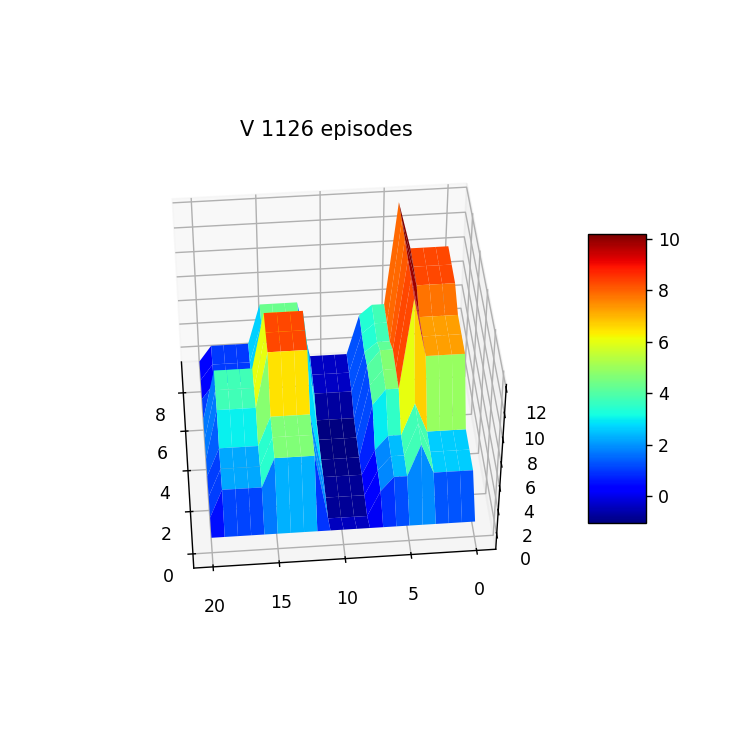

In [11]:
%matplotlib notebook
V = np.zeros((21, 10))
for j in range(21):
    for i in range(10):
        V[j][i] = np.max(Q[j][i])
X, Y = np.meshgrid(range(10), range(21))
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, V, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"V {best_i} episodes")
plt.savefig(f"V {best_i} episodes")
plt.show()

<IPython.core.display.Javascript object>


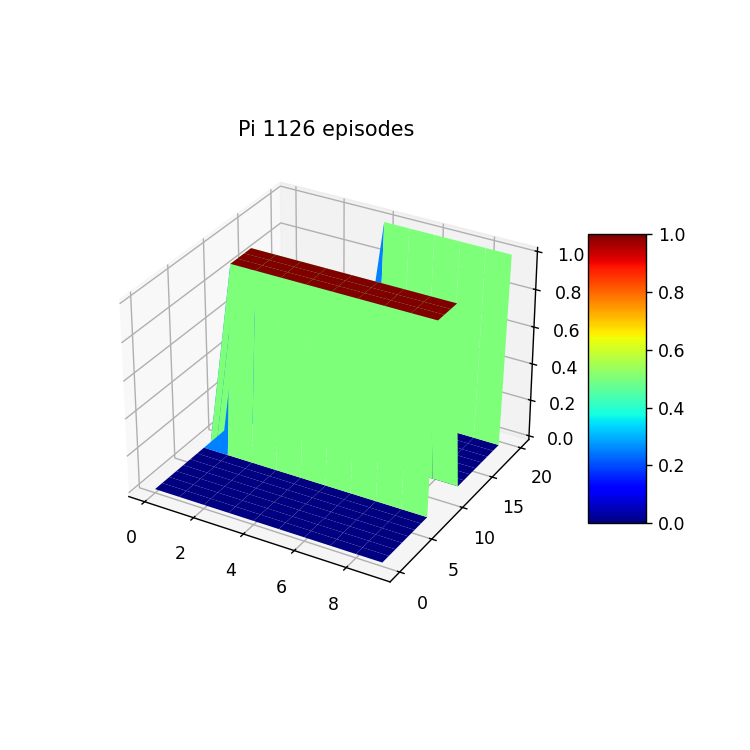

In [12]:
%matplotlib notebook
V = np.zeros((21, 10))
for j in range(21):
    for i in range(10):
        V[j][i] = np.argmax(Q[j][i])
X, Y = np.meshgrid(range(10), range(21))
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, V, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"Pi {best_i} episodes")
plt.savefig(f"Pi {best_i} episodes")
plt.show()

# Lam = 1

100%|███████████████████████████████████████| 2000/2000 [01:26<00:00, 23.20it/s]


<IPython.core.display.Javascript object>


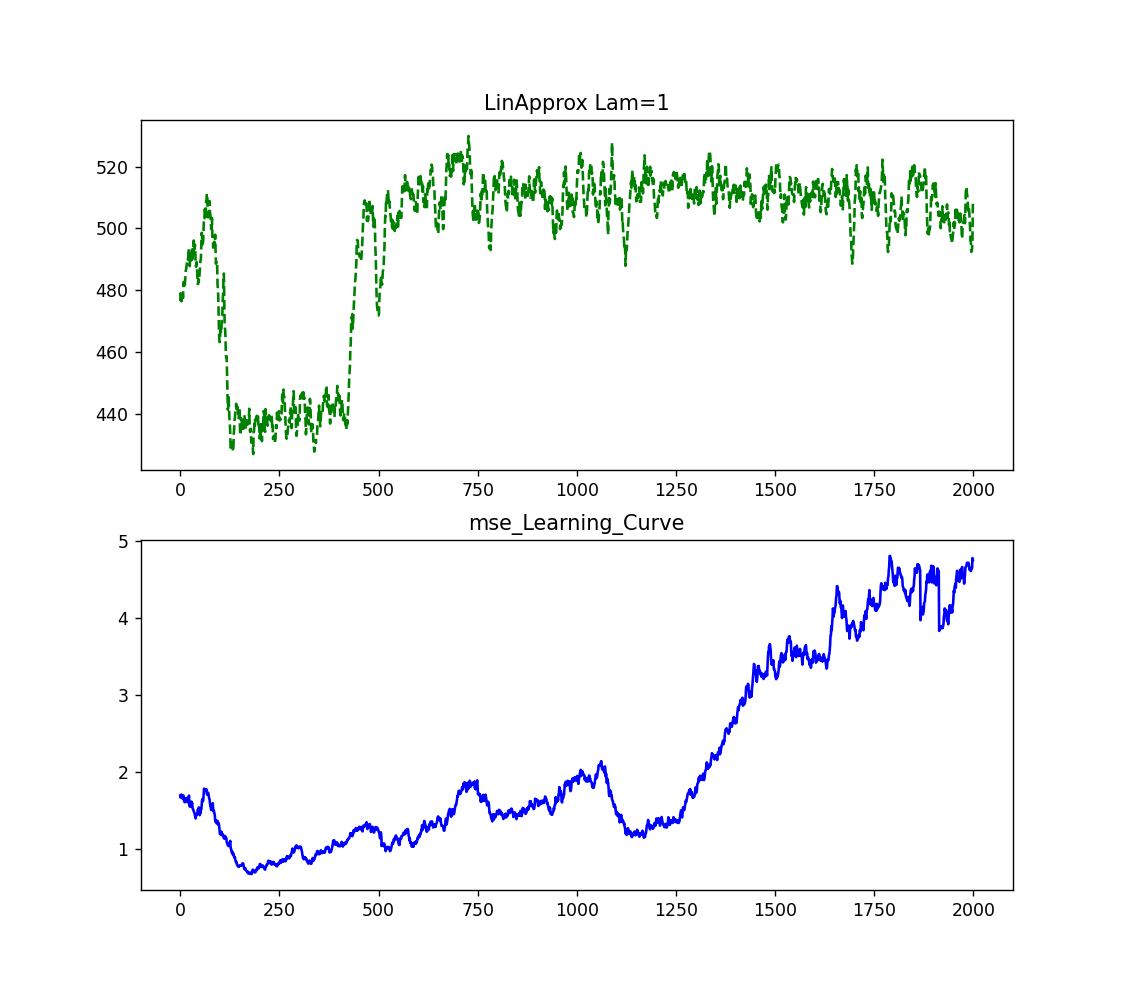

In [13]:
W = W_init.copy()
best = 0
win_history = []
mse_history = []

for i in trange(2000):
    mse_history.append(Lin_Approx(100, 0))
    win_history.append(benchmark())
    if np.average(win_history[-10:]) > best:
        np.save("Best_W_1.npy", W)
        best = np.average(win_history[-10:])
        best_i = i

rolling_wins =[]
roll = 10
i = 0

for i in range(len(win_history)):
    rolling_wins.append(np.average(win_history[i:i+roll]))

%matplotlib notebook
plt.figure(figsize=(9,8))
plt.subplot(2,1,1)
plt.plot(range(len(rolling_wins)), rolling_wins, 'g--')
plt.title("LinApprox Lam=1")
plt.subplot(2,1,2)
plt.plot(range(len(mse_history)), mse_history, 'b')
plt.title("mse_Learning_Curve")
plt.savefig("Lam=1")
plt.show()

# Trained Agent Performance

In [14]:
best_i

736

In [15]:
W = np.load("Best_W_1.npy")

wins = 0

for l in trange(1_00_000):
    curr = (np.random.choice(cards), np.random.choice(cards))
    act = get_lin_action(curr, W)
    S = enc_state(curr, act)
    
    t = 0

    while t == 0:
        curr_n, rew, t = step(curr, act)
        act_n = get_lin_action(curr_n, W)
        S_n = enc_state(curr_n, act_n)

        curr = curr_n
        act = act_n
        S = S_n

    if rew >= 0:
        wins+=1

print(wins)

100%|████████████████████████████████| 100000/100000 [00:04<00:00, 24989.27it/s]

51891


In [16]:
Q = np.zeros((21, 10,2))

for j in range(21):
    for i in range(10):
        for a in range(2):
            St = enc_state((j,i), a)
            Q[j][i][a] = np.einsum("l,l -> ", W, enc_state((j,i),a))

<IPython.core.display.Javascript object>


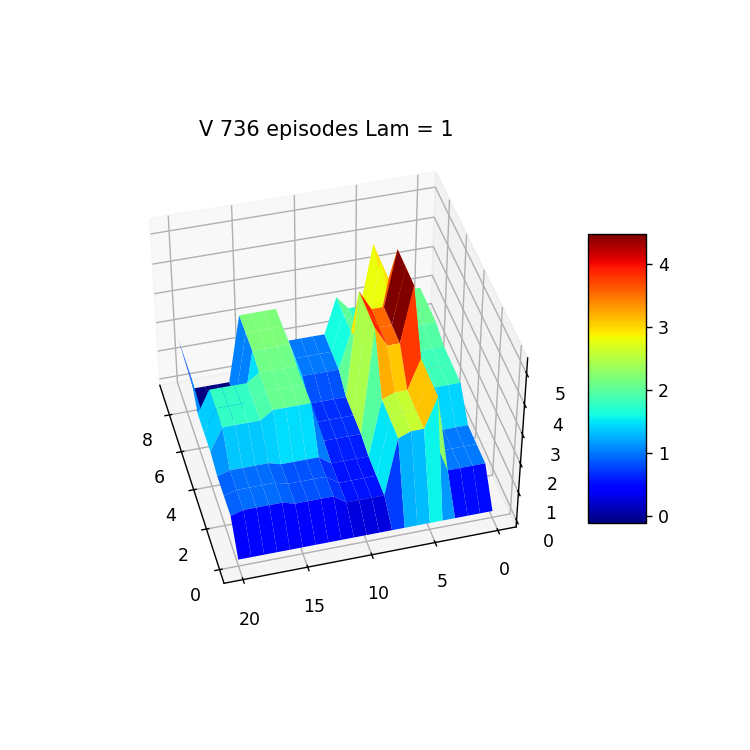

In [17]:
%matplotlib notebook
V = np.zeros((21, 10))
for j in range(21):
    for i in range(10):
        V[j][i] = np.max(Q[j][i])
X, Y = np.meshgrid(range(10), range(21))
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, V, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"V {best_i} episodes Lam = 1")
plt.savefig(f"V {best_i} episodes Lam = 1")
plt.show()

<IPython.core.display.Javascript object>


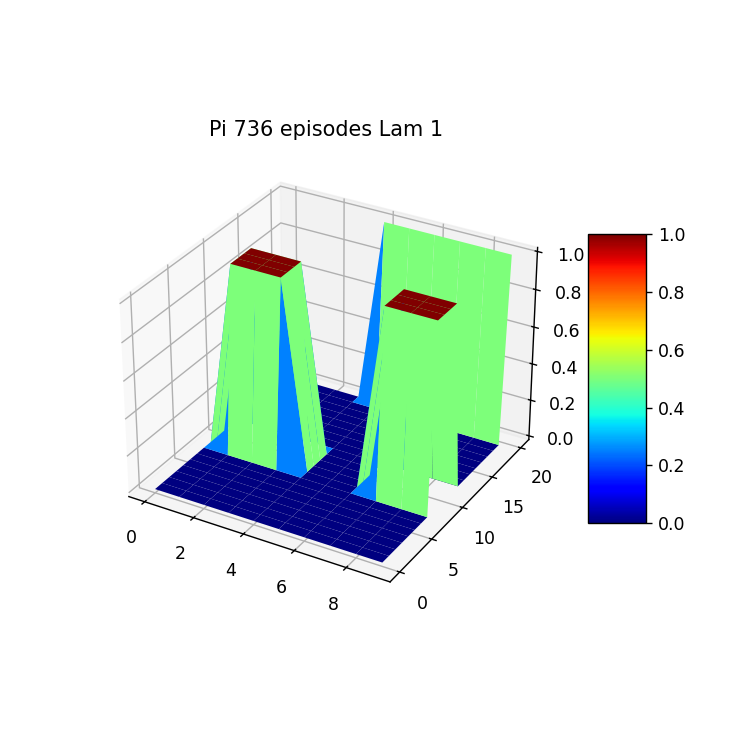

In [18]:
%matplotlib notebook
V = np.zeros((21, 10))
for j in range(21):
    for i in range(10):
        V[j][i] = np.argmax(Q[j][i])
X, Y = np.meshgrid(range(10), range(21))
fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection = '3d')
surf = ax.plot_surface(X, Y, V, cmap=cm.jet, linewidth=0.1)
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.title(f"Pi {best_i} episodes Lam 1")
plt.savefig(f"Pi {best_i} episodes Lam 1")
plt.show()